In [58]:
# !pip install numpy==1.24.4
# !pip install seaborn
# !pip install phik
# !pip install shap

!pip install -r requirements.txt
!pip freeze > requirements.txt

Processing c:\b\abs_816hr2khp1\croot\bottleneck_1731058648110\work (from -r requirements.txt (line 11))


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\b\\abs_816hr2khp1\\croot\\bottleneck_1731058648110\\work'



### Цель проекта
Предсказать вероятность покупки в течение 90 дней в Интернет-магазине 
### Задачи

● Изучить данные

● Разработать полезные признаки

● Создать модель для классификации пользователей

● Улучшить модель и максимизировать метрику roc_auc. Выйти на целевой показатель > 70%

● Выполнить тестирование

### Данные которыми располагаем

● История покупок apparel-purchases

● История рекламных рассылок apparel-messages

● Целевой признак target


#### Импортируем необходимые библиотеки. Загрузим данные. Посмотрим типы данных

In [2]:
import pandas as pd

import numpy as np

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import HistGradientBoostingClassifier

from matplotlib import pyplot as plt

from imblearn.over_sampling import ADASYN

import seaborn as sns

from sklearn.model_selection import train_test_split 

from sklearn.metrics import recall_score

from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score,  
    confusion_matrix,
    roc_auc_score,
    f1_score)


import phik

import shap

from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,   
    StandardScaler,  
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder
                                  )
   
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction import FeatureHasher

import ast

from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
pd.set_option('display.max_columns', 36)
apparel_messages = pd.read_csv(r"C:\Users\grigr\Desktop\master 2\apparel-messages.csv")
apparel_purchases = pd.read_csv(r"C:\Users\grigr\Desktop\master 2\apparel-purchases.csv")
apparel_target_binary= pd.read_csv(r"C:\Users\grigr\Desktop\master 2\apparel-target_binary.csv")



In [4]:
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [5]:
apparel_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [6]:
apparel_target_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [7]:
apparel_messages

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
...,...,...,...,...,...,...,...
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40


In [8]:
apparel_purchases

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


In [9]:
apparel_target_binary

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
...,...,...
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0


In [10]:
apparel_purchases.info()
apparel_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [11]:
apparel_purchases.duplicated().sum()

73020

In [12]:
apparel_messages.duplicated().sum()

48610

In [13]:
apparel_messages = apparel_messages.drop_duplicates()

In [14]:
len(apparel_purchases['client_id'].unique())

49849

**Промежуточный вывод блока**
* Данные не имеют пропуски.
* Даты имеют некорректный тип данных
* Данные в истории покупок имеют дубликаты. В истории покупок они занимают более 30%. Скорее всего это связано с тем, что клиент мог делать несколько покупок в один день. Дубликаты не будут удалятся или заменяться
* Данные в истории уведомлений имеют пропуски и буду удалены. Они занимают менее 10% всего df
* Мы имеем всего 49849 уникальных клиентов
    

### Проведу EDA для категориальных признаков. События и по виду канала отправки сообщений

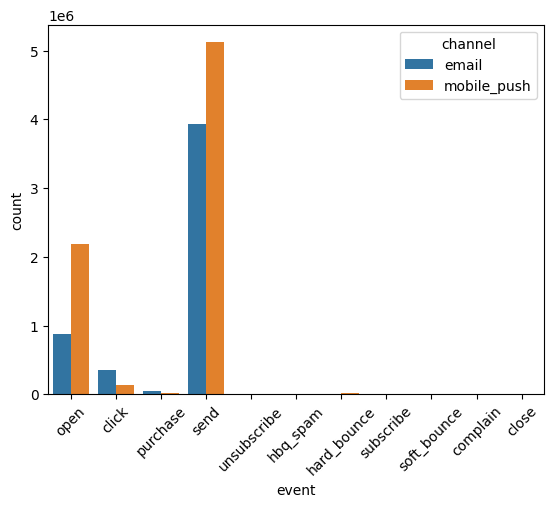

In [15]:
sns.countplot(data = apparel_messages, x = 'event', hue = 'channel')
plt.xticks(rotation=45);

**Промежуточный вывод блока**

Можно предположить, что конвертация от отправленных сообщений в покупки менее 10%. Большая часть сообщений отправляются в виде пуш уведомлений

### Создание новых признаков через агрегацию данных

In [16]:
apparel_purchases.columns

Index(['client_id', 'quantity', 'price', 'category_ids', 'date', 'message_id'], dtype='object')

In [17]:
aggregate_purchases = apparel_purchases.groupby('client_id').agg(
    total_price = ('price' , 'sum') ,
    total_quantity = ('quantity' , 'sum')
).reset_index()
aggregate_purchases['upt'] =  aggregate_purchases['total_price'] /aggregate_purchases['total_quantity']
aggregate_purchases['upt_sqrt'] =aggregate_purchases['upt']**2
aggregate_purchases

,client_id,total_price,total_quantity,upt,upt_sqrt
0,1515915625468060902,6993.0,7,999.000000,9.980010e+05
1,1515915625468061003,16235.0,7,2319.285714,5.379086e+06
2,1515915625468061099,299.0,1,299.000000,8.940100e+04
3,1515915625468061100,2098.0,2,1049.000000,1.100401e+06
4,1515915625468061170,33601.0,19,1768.473684,3.127499e+06
...,...,...,...,...,...
49844,1515915626010261344,8994.0,6,1499.000000,2.247001e+06
49845,1515915626010266132,1818.0,2,909.000000,8.262810e+05
49846,1515915626010439406,198.0,2,99.000000,9.801000e+03
49847,1515915626010443527,1999.0,1,1999.000000,3.996001e+06


In [18]:
apparel_messages.columns

Index(['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel',
       'date', 'created_at'],
      dtype='object')

In [19]:
apparel_messages

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
...,...,...,...,...,...,...,...
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40


In [20]:

apparel_messages['is_mobile'] = (apparel_messages['channel'] == 'mobile_push').astype(int)
apparel_messages['is_email'] = (apparel_messages['channel'] == 'email').astype(int)
apparel_messages['open'] = (apparel_messages['event'] == 'open').astype(int)
apparel_messages['click'] = (apparel_messages['event'] == 'click').astype(int)
apparel_messages['purchase'] = (apparel_messages['event'] == 'purchase').astype(int)
apparel_messages['send'] = (apparel_messages['event'] == 'send').astype(int)
apparel_messages['hard_bounce'] = (apparel_messages['event'] == 'hard_bounce').astype(int)


aggregate_messages = apparel_messages.groupby('client_id').agg(
    total_event = ('event', 'count'),
    total_channel_mobile = ('is_mobile', 'sum'),
    total_channel_email = ('is_email', 'sum'),
    total_open = ('open', 'sum'),
    total_click = ('click', 'sum'),
    total_purchase = ('purchase', 'sum'),
    total_send = ('send', 'sum'),
    total_hard_bounce = ('hard_bounce', 'sum')
               
).reset_index()

C:\Users\grigr\AppData\Local\Temp\ipykernel_8368\1878225057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apparel_messages['is_mobile'] = (apparel_messages['channel'] == 'mobile_push').astype(int)
C:\Users\grigr\AppData\Local\Temp\ipykernel_8368\1878225057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apparel_messages['is_email'] = (apparel_messages['channel'] == 'email').astype(int)
C:\Users\grigr\AppData\Local\Temp\ipykernel_8368\1878225057.py:3: SettingWithCopyWarning: 
A value is trying to b

In [21]:
aggregate_messages

,client_id,total_event,total_channel_mobile,total_channel_email,total_open,total_click,total_purchase,total_send,total_hard_bounce
0,1515915625468060902,177,0,177,35,10,5,126,0
1,1515915625468061003,165,0,165,5,5,1,154,0
2,1515915625468061099,276,94,182,51,8,0,215,2
3,1515915625468061100,428,428,0,157,1,1,267,1
4,1515915625468061170,293,91,202,31,16,3,243,0
...,...,...,...,...,...,...,...,...,...
53324,1515915626010183608,4,4,0,2,0,0,2,0
53325,1515915626010221592,6,6,0,2,2,0,2,0
53326,1515915626010234726,1,1,0,0,0,0,1,0
53327,1515915626010261344,3,3,0,1,1,0,1,0


In [22]:
apparel_purchases

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


In [23]:
apparel_mes_pus_full_sample = aggregate_messages.merge(apparel_target_binary, on = 'client_id')

In [24]:
apparel_mes_pus_full_sample = apparel_mes_pus_full_sample.merge(aggregate_purchases,on = 'client_id')

In [25]:
apparel_mes_pus_full_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             41982 non-null  int64  
 1   total_event           41982 non-null  int64  
 2   total_channel_mobile  41982 non-null  int32  
 3   total_channel_email   41982 non-null  int32  
 4   total_open            41982 non-null  int32  
 5   total_click           41982 non-null  int32  
 6   total_purchase        41982 non-null  int32  
 7   total_send            41982 non-null  int32  
 8   total_hard_bounce     41982 non-null  int32  
 9   target                41982 non-null  int64  
 10  total_price           41982 non-null  float64
 11  total_quantity        41982 non-null  int64  
 12  upt                   41982 non-null  float64
 13  upt_sqrt              41982 non-null  float64
dtypes: float64(3), int32(7), int64(4)
memory usage: 3.4 MB


In [26]:
apparel_mes_pus_full_sample.isna().sum()

client_id               0
total_event             0
total_channel_mobile    0
total_channel_email     0
total_open              0
total_click             0
total_purchase          0
total_send              0
total_hard_bounce       0
target                  0
total_price             0
total_quantity          0
upt                     0
upt_sqrt                0
dtype: int64

In [27]:
apparel_mes_pus_full_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             41982 non-null  int64  
 1   total_event           41982 non-null  int64  
 2   total_channel_mobile  41982 non-null  int32  
 3   total_channel_email   41982 non-null  int32  
 4   total_open            41982 non-null  int32  
 5   total_click           41982 non-null  int32  
 6   total_purchase        41982 non-null  int32  
 7   total_send            41982 non-null  int32  
 8   total_hard_bounce     41982 non-null  int32  
 9   target                41982 non-null  int64  
 10  total_price           41982 non-null  float64
 11  total_quantity        41982 non-null  int64  
 12  upt                   41982 non-null  float64
 13  upt_sqrt              41982 non-null  float64
dtypes: float64(3), int32(7), int64(4)
memory usage: 3.4 MB


**Промежуточный вывод блока**

Одназначно имеет смысл агрегировать данные по каждому клиенту. Это касается истории покупок и истории сообщений. Я взял не все события связанные с историей сообщений, а только те, которые показали свое количество на гистограмме.
В общем итоге количественные признаки приведены в суммарные значения. Категориальные признаки также приведены к суммарным значениям. Я создал средний чек по каждому клиенту и попробовал возвести в квадрат, в надежде, что это сможет улучшить зависимость


### Построю матрицу корреляции для отслеживания зависимости между признаками

In [28]:
apparel_mes_pus_full_sample.columns

Index(['client_id', 'total_event', 'total_channel_mobile',
       'total_channel_email', 'total_open', 'total_click', 'total_purchase',
       'total_send', 'total_hard_bounce', 'target', 'total_price',
       'total_quantity', 'upt', 'upt_sqrt'],
      dtype='object')

In [29]:
apparel_mes_pus_full_sample

,client_id,total_event,total_channel_mobile,total_channel_email,total_open,total_click,total_purchase,total_send,total_hard_bounce,target,total_price,total_quantity,upt,upt_sqrt
0,1515915625468060902,177,0,177,35,10,5,126,0,0,6993.0,7,999.000000,9.980010e+05
1,1515915625468061003,165,0,165,5,5,1,154,0,1,16235.0,7,2319.285714,5.379086e+06
2,1515915625468061099,276,94,182,51,8,0,215,2,0,299.0,1,299.000000,8.940100e+04
3,1515915625468061100,428,428,0,157,1,1,267,1,0,2098.0,2,1049.000000,1.100401e+06
4,1515915625468061170,293,91,202,31,16,3,243,0,0,33601.0,19,1768.473684,3.127499e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41977,1515915626010079153,3,3,0,0,1,1,1,0,0,15929.0,8,1991.125000,3.964579e+06
41978,1515915626010152263,5,5,0,0,2,2,1,0,0,1676.0,4,419.000000,1.755610e+05
41979,1515915626010183608,4,4,0,2,0,0,2,0,0,568.0,4,142.000000,2.016400e+04
41980,1515915626010221592,6,6,0,2,2,0,2,0,0,2998.0,2,1499.000000,2.247001e+06


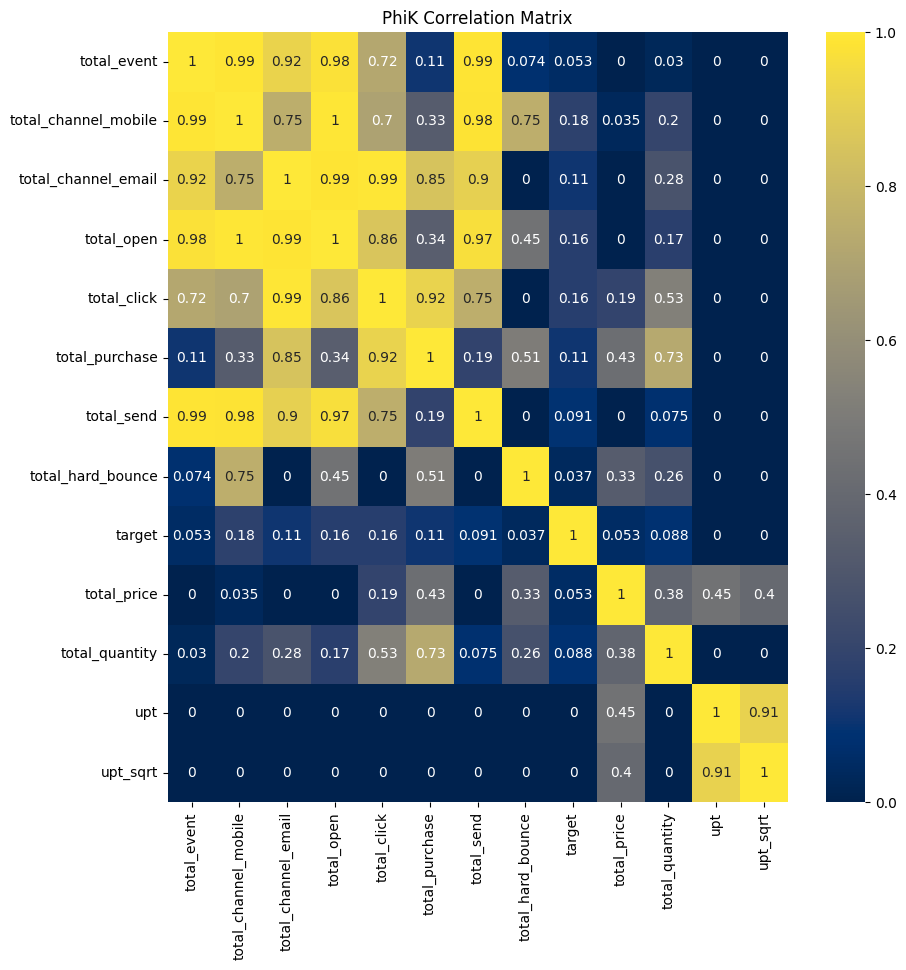

In [30]:
num_col_for_phik = ['price', 'quantity', 'total_quantity', 'total_price', 'upt','upt_sqrt','total_event','total_channel' ]
phik_matrix_result = apparel_mes_pus_full_sample.drop(['client_id'], axis =1).phik_matrix(interval_cols= num_col_for_phik)
plt.figure(figsize=(10, 10))  
sns.heatmap(phik_matrix_result, annot=True, cmap='cividis')
plt.title('PhiK Correlation Matrix') 
plt.show() 

**Промежуточный вывод блока**

Можно наблюдать линейную зависимость между агрегированными признаками. Но не всеми.
 * Срдений чек и его возведение в квадрат не дает никакого результата и зависимости между целевым признаком. Признаки не буду использоваться в модели
 * Мы наблюдаем сильную сультиколлеарность между признаками: сумма событий и суммы событий каждой из категории. Общая сумма всех событий не будет использоваться в модели
 * Общая сумма всех покупок и количество всех покупок не имеют практически корреляции с целевым признаком. Признаки не будут использоваться в модели
 * Остается небольшое количество признаков для обучения модели.

Скорее всего признака category_ids замаскирован. Его необходимо обработать. Есть несколько способов преобразовать признак 

### Обучим первую модель и получим результаты

In [31]:

TEST_SIZE = 0.25
RANDOM_STATE = 42
model = HistGradientBoostingClassifier(random_state=42)
X = apparel_mes_pus_full_sample.drop(['target', 'client_id','total_price', 'total_quantity', 'upt', 'upt_sqrt',
       'total_event', 'total_send'], axis=1)

y = apparel_mes_pus_full_sample['target']


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

model.fit(X_temp, y_temp)
y_temp = model.predict(X_test) 

In [32]:
y_temp = model.predict_proba(X_test)[:,1]
roc_auc_valid = roc_auc_score(y_test, y_temp)
print(f'ROC-AUC: {roc_auc_valid:.4f}')

ROC-AUC: 0.6857


**Промежуточный вывод блока**

Мы не получили целевой показатель метрики. Нужно поработать над признаками

**Добавляю категорию товаров к df**

In [33]:
apparel_purchases

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


In [34]:

apparel_purchases['category_first']  = apparel_purchases['category_ids'].str.replace(r"[\[\]' ]","", regex = True).str.split(',')

In [35]:
apparel_purchases

,client_id,quantity,price,category_ids,date,message_id,category_first
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]"
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,"[4, 28, 57, 431]"
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,"[4, 28, 57, 431]"
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,"[4, 28, 244, 432]"
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,"[4, 28, 49, 413]"
...,...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,"[2, 18, 212, 726]"
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,"[4, 27, 233, 462]"
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,"[4, 27, 233, 462]"
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,"[2, 18, 274, 446]"


In [36]:
df_full =  apparel_purchases.explode('category_first', ignore_index = True)


In [37]:
for i in range(4):
    apparel_purchases[f'cat_{i+1}'] =apparel_purchases['category_first'].apply(lambda x: x[i] if i <len(x) else None)

In [38]:
category_agregate = apparel_purchases.groupby('client_id').agg(

    cat_1_total = ('cat_1' , 'count'), 
    cat_2_total = ('cat_2' , 'count'), 
    cat_3_total = ('cat_3' , 'count'), 
    cat_4_total = ('cat_4' , 'count') 
)

In [39]:
category_agregate

,cat_1_total,cat_2_total,cat_3_total,cat_4_total
client_id,,,,
1515915625468060902,7,7,7,7
1515915625468061003,7,7,7,7
1515915625468061099,1,1,1,1
1515915625468061100,2,2,2,2
1515915625468061170,19,17,17,17
...,...,...,...,...
1515915626010261344,6,6,6,6
1515915626010266132,2,2,2,2
1515915626010439406,2,2,2,2


In [40]:
apparel_mes_pus_full_sample = apparel_mes_pus_full_sample.merge(category_agregate, on ='client_id')

In [41]:
apparel_mes_pus_full_sample

,client_id,total_event,total_channel_mobile,total_channel_email,total_open,total_click,total_purchase,total_send,total_hard_bounce,target,total_price,total_quantity,upt,upt_sqrt,cat_1_total,cat_2_total,cat_3_total,cat_4_total
0,1515915625468060902,177,0,177,35,10,5,126,0,0,6993.0,7,999.000000,9.980010e+05,7,7,7,7
1,1515915625468061003,165,0,165,5,5,1,154,0,1,16235.0,7,2319.285714,5.379086e+06,7,7,7,7
2,1515915625468061099,276,94,182,51,8,0,215,2,0,299.0,1,299.000000,8.940100e+04,1,1,1,1
3,1515915625468061100,428,428,0,157,1,1,267,1,0,2098.0,2,1049.000000,1.100401e+06,2,2,2,2
4,1515915625468061170,293,91,202,31,16,3,243,0,0,33601.0,19,1768.473684,3.127499e+06,19,17,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41977,1515915626010079153,3,3,0,0,1,1,1,0,0,15929.0,8,1991.125000,3.964579e+06,8,8,8,8
41978,1515915626010152263,5,5,0,0,2,2,1,0,0,1676.0,4,419.000000,1.755610e+05,4,4,4,4
41979,1515915626010183608,4,4,0,2,0,0,2,0,0,568.0,4,142.000000,2.016400e+04,4,2,2,2
41980,1515915626010221592,6,6,0,2,2,0,2,0,0,2998.0,2,1499.000000,2.247001e+06,2,2,2,2


In [42]:
apparel_mes_pus_full_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41982 entries, 0 to 41981
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             41982 non-null  int64  
 1   total_event           41982 non-null  int64  
 2   total_channel_mobile  41982 non-null  int32  
 3   total_channel_email   41982 non-null  int32  
 4   total_open            41982 non-null  int32  
 5   total_click           41982 non-null  int32  
 6   total_purchase        41982 non-null  int32  
 7   total_send            41982 non-null  int32  
 8   total_hard_bounce     41982 non-null  int32  
 9   target                41982 non-null  int64  
 10  total_price           41982 non-null  float64
 11  total_quantity        41982 non-null  int64  
 12  upt                   41982 non-null  float64
 13  upt_sqrt              41982 non-null  float64
 14  cat_1_total           41982 non-null  int64  
 15  cat_2_total        

* Оцениваем корреляцию с новыми признаками
* Добавляем новые признаки к обучению.
* Разбиваем данные на тренировочные, валидационные и тестовые
* Кодируем целевой признак
* Обучаем модель на новых данных

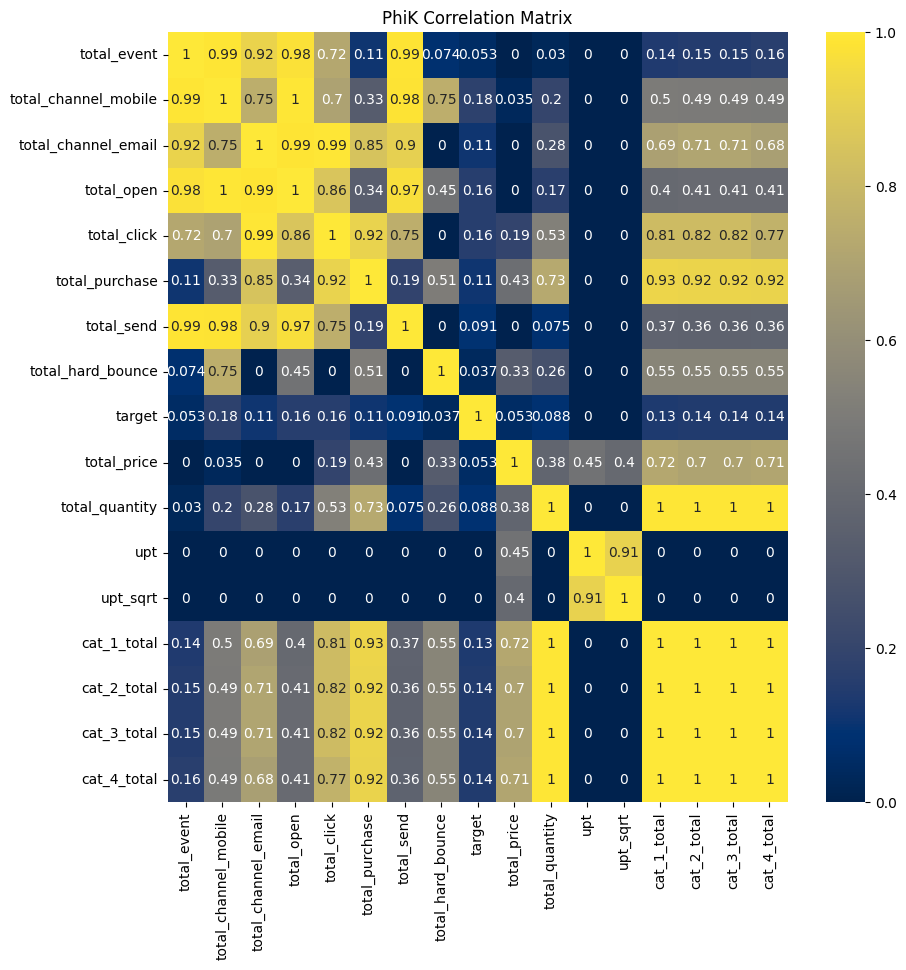

In [43]:
num_col_for_phik = ['price', 'quantity', 'total_quantity', 'total_price', 'upt','upt_sqrt','total_event','total_channel' ]
phik_matrix_result = apparel_mes_pus_full_sample.drop(['client_id'], axis =1).phik_matrix(interval_cols= num_col_for_phik)
plt.figure(figsize=(10, 10))  
sns.heatmap(phik_matrix_result, annot=True, cmap='cividis')
plt.title('PhiK Correlation Matrix') 
plt.show() 

In [44]:

TEST_SIZE = 0.40
VALID_SIZE = 0.25
RANDOM_STATE = 42
model_better = HistGradientBoostingClassifier(random_state=42)
X = apparel_mes_pus_full_sample.drop(['target', 'client_id','total_price', 'total_quantity', 'upt', 'upt_sqrt',
       'total_event', 'total_send'], axis=1)
y = apparel_mes_pus_full_sample['target']


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=VALID_SIZE, random_state=RANDOM_STATE)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc = le.transform(y_test)



In [45]:
model_better.fit(X_train, y_train_enc)
y_valid_pred = model_better.predict(X_valid) 
y_pred2 = model_better.predict(X_test)


In [46]:
pd.Series(y_train_enc).value_counts(normalize=True)

0    0.979355
1    0.020645
Name: proportion, dtype: float64

In [47]:
y_valid_pred  = model_better.predict_proba(X_valid)[:,1]
roc_auc_valid = roc_auc_score(y_valid_enc, y_valid_pred)
print(f'ROC-AUC: {roc_auc_valid:.4f}')

ROC-AUC: 0.6803


In [48]:
y_pred_proba2 = model_better.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
roc_auc = roc_auc_score(y_test_enc, y_pred_proba2)

print(f'ROC-AUC: {roc_auc:.4f}')

ROC-AUC: 0.7023


**Получен целевой показатель по метрике. Более 70%**

### Интерпритируем признаки.

* Строю графики шап значений и влияния признаков на модель
* График рок-аук


In [49]:
explainer = shap.Explainer(model_better.predict_proba, X_test)
shap_values = explainer(X_test)



ExactExplainer explainer: 16794it [10:27, 26.53it/s]                                                                                                                                                    


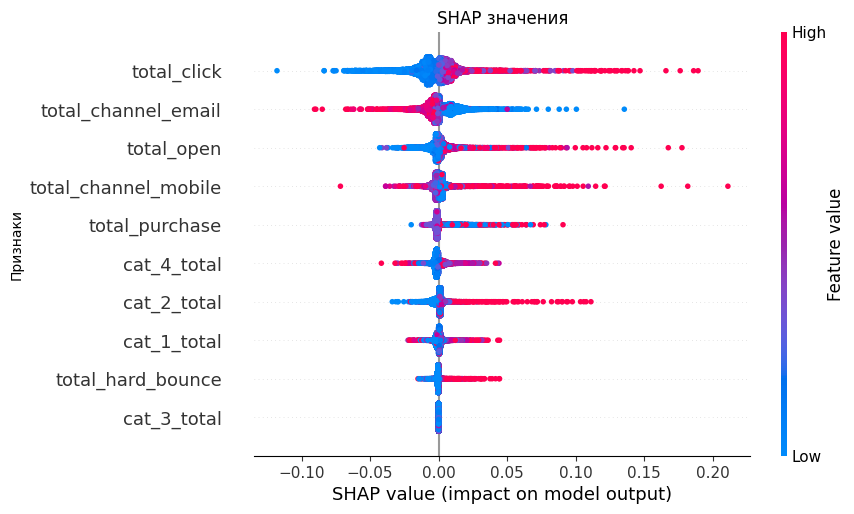

In [50]:
shap.plots.beeswarm(shap_values[:,:,1],max_display=22, show=False)
plt.ylabel('Признаки')
plt.title('SHAP значения')
plt.show()

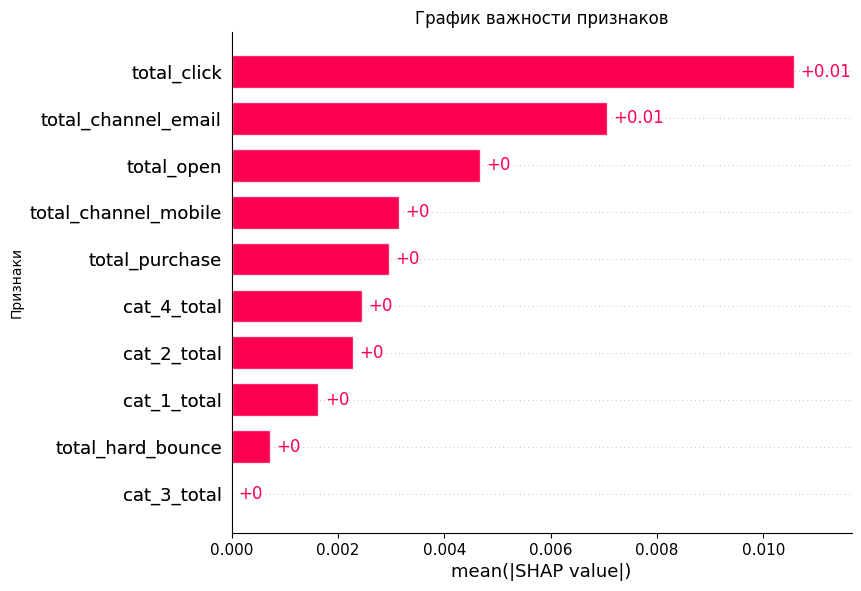

In [51]:
shap.plots.bar(shap_values[:,:, 1], max_display=22, show=False)
plt.ylabel('Признаки')
plt.title('График важности признаков')
plt.show()

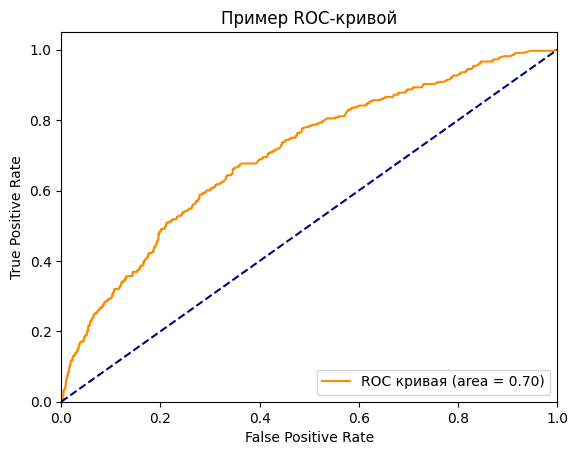

In [52]:
fpr, tpr, treshold = roc_curve(y_test_enc, y_pred_proba2)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

### Общий вывод проекта

* Изучены данные. Подготовлены промежуточные выводы
* Сгенерированны новые признаки для моделей. Основная концепция сгенерированных признаков - агрегация. По каждому клиенту были агрегоированы данные: общее количество событий, общая сумма покупки, общее количество покупок, общее количество единиц товара, общее количество каждой категории товара
* Приведен анализ корреляции. Улучшена целевая метрика
* В самих моделях не были использованы признаки с нулевой, слабой, мульти корреляцией.
* Достигнут целевой показатель по метрике ROC-AUC 70%
* Интепритированы признаки. Визуально с помощью shap графика показан вклад каждого признака в модель.
* Построен график roc кривой. Кривая вызывает некоторые опасения. Слишком стремительно движется от оси Y. Я связываю это с дисбалансом целевого таргета. Ощущение, что модель плохо предсказывает класс '1'. Я не стал двигать порог классификации так как не увидел для этого смысла в конкретной задаче. 